In [ ]:
# Mounting Google Drive locally

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
# !pip install pmdarima
from pmdarima.arima import auto_arima
std=StandardScaler()
#pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [ ]:
covid=pd.read_csv("/content/drive/Shareddrives/BOT-DL/archive/covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [ ]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (306429, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     78100
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [ ]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)

In [ ]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])


In [ ]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
grouped_country["Active Cases"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active Cases"])

In [ ]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [ ]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  229
Total number of Confirmed Cases around the World:  169951560.0
Total number of Recovered Cases around the World:  107140669.0
Total number of Deaths Cases around the World:  3533619.0
Total number of Active Cases around the World:  59277272.0
Total number of Closed Cases around the World:  110674288.0
Approximate number of Confirmed Cases per Day around the World:  344031.0
Approximate number of Recovered Cases per Day around the World:  216884.0
Approximate number of Death Cases per Day around the World:  7153.0
Approximate number of Confirmed Cases per hour around the World:  14335.0
Approximate number of Recovered Cases per hour around the World:  9037.0
Approximate number of Death Cases per hour around the World:  298.0
Number of Confirmed Cases in last 24 hours:  480835.0
Number of Recovered Cases in last 24 hours:  507600.0
Number of Death Cases in last 24 hours:  10502.0


In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [ ]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
# Growth rate of Confirmed, Recovered and Death Cases

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
# Moratality and Recovery Rate analysis around the World
#Calculating the Mortality Rate and Recovery Rate
# Mortality rate = (Number of Death Cases / Number of Confirmed Cases) x 100
# Recovery Rate= (Number of Recoverd Cases / Number of Confirmed Cases) x 100

datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 3.3985574175088837
Median Mortality Rate 2.772038814120292
Average Recovery Rate 51.14820182446859
Median Recovery Rate 56.426751740200025


In [ ]:
# Finding the average stats

print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  344030.0
Average increase in number of Recovered Cases every day:  216884.0
Average increase in number of Deaths Cases every day:  7153.0


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
# Growth Factor
# Formula: Every day's new (Confirmed,Recovered,Deaths) / new (Confirmed,Recovered,Deaths) on the previous day.

print("Average growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).mean())
print("Median growth factor of number of Confirmed Cases: ",(datewise["Confirmed"]/datewise["Confirmed"].shift()).median())
print("Average growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).mean())
print("Median growth factor of number of Recovered Cases: ",(datewise["Recovered"]/datewise["Recovered"].shift()).median())
print("Average growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).mean())
print("Median growth factor of number of Death Cases: ",(datewise["Deaths"]/datewise["Deaths"].shift()).median())

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"]/datewise["Confirmed"].shift(),
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"]/datewise["Recovered"].shift(),
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"]/datewise["Deaths"].shift(),
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of different types of cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

Average growth factor of number of Confirmed Cases:  1.0281591322080437
Median growth factor of number of Confirmed Cases:  1.0105328040968438
Average growth factor of number of Recovered Cases:  1.0337833427734546
Median growth factor of number of Recovered Cases:  1.0112782082196978
Average growth factor of number of Death Cases:  1.0273125837136605
Median growth factor of number of Death Cases:  1.0071398973639754


In [ ]:
# Growth Factor for Active and Closed Cases
# Formula: Every day's new (Active and Closed Cases) / new (Active and Closed Cases) on the previous day.

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, 
                         y=(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])/(datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Active Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=(datewise["Recovered"]+datewise["Deaths"])/(datewise["Recovered"]+datewise["Deaths"]).shift(),
                    mode='lines',
                    name='Growth Factor of Closed Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed Cases",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=-0.4,traceorder="normal"))
fig.show()

In [ ]:
# Rate of Doubling for Confirmed Cases around the World
c=560
double_days=[]
C=[]
while(1):
    double_days.append(datewise[datewise["Confirmed"]<=c].iloc[[-1]]["Days Since"][0])
    C.append(c)
    c=c*2
    if(c<datewise["Confirmed"].max()):
        continue
    else:
        break

In [ ]:
doubling_rate=pd.DataFrame(list(zip(C,double_days)),columns=["No. of cases","Days since first Case"])
doubling_rate["Number of days for doubling"]=doubling_rate["Days since first Case"].diff().fillna(doubling_rate["Days since first Case"])
doubling_rate

,No. of cases,Days since first Case,Number of days for doubling
0,560,0 days,0 days
1,1120,2 days,2 days
2,2240,4 days,2 days
3,4480,5 days,1 days
4,8960,8 days,3 days
5,17920,11 days,3 days
6,35840,16 days,5 days
7,71680,25 days,9 days
8,143360,50 days,25 days
9,286720,58 days,8 days


In [ ]:
# Number of days requried for increase in Confirmed Cases by 300K

c1=100000
days_300k=[]
C1=[]
while(1):
    days_300k.append(datewise[datewise["Confirmed"]<=c1].iloc[[-1]]["Days Since"][0])
    C1.append(c1)
    c1=c1+300000
    if(c1<datewise["Confirmed"].max()):
        continue
    else:
        break


In [ ]:
rate_300k=pd.DataFrame(list(zip(C1,days_300k)),columns=["No. of Cases","Days Since first Case"])
rate_300k["Days requried for rise of 300K"]=rate_300k["Days Since first Case"].diff().fillna(rate_300k["Days Since first Case"].iloc[[0]][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=rate_300k["No. of Cases"], y=rate_300k["Days requried for rise of 300K"].dt.days,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.update_layout(title="Number of Days required for increase in number of cases by 300K",
                 xaxis_title="Number of Cases",yaxis_title="Number of Days")
fig.show()

# Data Analysis for India

In [ ]:
india_data=covid[covid["Country/Region"]=="India"]
datewise_india=india_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
print(datewise_india.iloc[-1])
print("Total Active Cases: ",datewise_india["Confirmed"].iloc[-1]-datewise_india["Recovered"].iloc[-1]-datewise_india["Deaths"].iloc[-1])
print("Total Closed Cases: ",datewise_india["Recovered"].iloc[-1]+datewise_india["Deaths"].iloc[-1])

Confirmed    27894800.0
Recovered    25454320.0
Deaths         325972.0
Name: 2021-05-29 00:00:00, dtype: float64
Total Active Cases:  2114508.0
Total Closed Cases:  25780292.0


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=px.bar(x=datewise_india.index,y=datewise_india["Confirmed"]-datewise_india["Recovered"]-datewise_india["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases in India",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [ ]:
india_increase_confirm=[]
india_increase_recover=[]
india_increase_deaths=[]
for i in range(datewise_india.shape[0]-1):
    india_increase_confirm.append(((datewise_india["Confirmed"].iloc[i+1])/datewise_india["Confirmed"].iloc[i]))
    india_increase_recover.append(((datewise_india["Recovered"].iloc[i+1])/datewise_india["Recovered"].iloc[i]))
    india_increase_deaths.append(((datewise_india["Deaths"].iloc[i+1])/datewise_india["Deaths"].iloc[i]))
india_increase_confirm.insert(0,1)
india_increase_recover.insert(0,1)
india_increase_deaths.insert(0,1)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_confirm,
                    mode='lines',
                    name='Growth Factor of Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_recover,
                    mode='lines',
                    name='Growth Factor of Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=india_increase_deaths,
                    mode='lines',
                    name='Growth Factor of Death Cases'))
fig.update_layout(title="Datewise Growth Factor of Active and Closed cases in India",
                 xaxis_title="Date",yaxis_title="Growth Factor",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Recovered"].diff().fillna(0),
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Deaths"].diff().fillna(0),
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of cases in India",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
datewise_india["WeekOfYear"]=datewise_india.index.weekofyear

week_num_india=[]
india_weekwise_confirmed=[]
india_weekwise_recovered=[]
india_weekwise_deaths=[]
w=1
for i in list(datewise_india["WeekOfYear"].unique()):
    india_weekwise_confirmed.append(datewise_india[datewise_india["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    india_weekwise_recovered.append(datewise_india[datewise_india["WeekOfYear"]==i]["Recovered"].iloc[-1])
    india_weekwise_deaths.append(datewise_india[datewise_india["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num_india.append(w)
    w=w+1
    
fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num_india, y=india_weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth of different types of Cases in India",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, "India's Weekwise increase in Number of Death Cases")

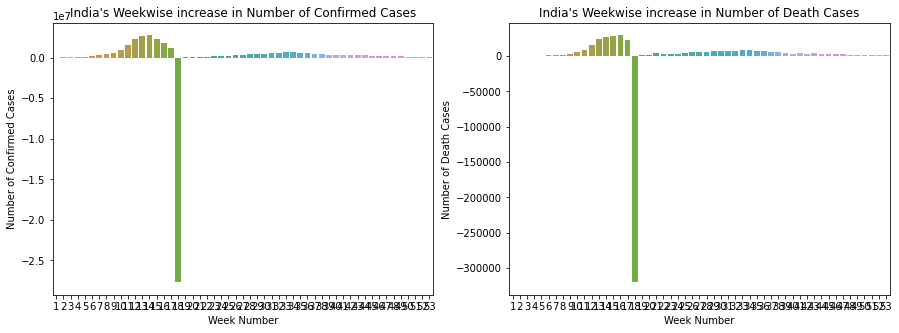

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num_india,y=pd.Series(india_weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("India's Weekwise increase in Number of Confirmed Cases")
ax2.set_title("India's Weekwise increase in Number of Death Cases")

In [ ]:
# Comparison of China, Italy, US, Spain, Brazil and Rest of the World

china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
US_data=covid[covid["Country/Region"]=="US"]
spain_data=covid[covid["Country/Region"]=="Spain"]
brazil_data=covid[covid["Country/Region"]=="Brazil"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Italy")&(covid["Country/Region"]!="US")&(covid["Country/Region"]!="Spain")&(covid["Country/Region"]!="Brazil")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_US=US_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Spain=spain_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Brazil=brazil_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [ ]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_US["Mortality"]=(datewise_US["Deaths"]/datewise_US["Confirmed"])*100
datewise_Spain["Mortality"]=(datewise_Spain["Deaths"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Mortality"]=(datewise_Brazil["Deaths"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100

datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_US["Recovery"]=(datewise_US["Recovered"]/datewise_US["Confirmed"])*100
datewise_Spain["Recovery"]=(datewise_Spain["Recovered"]/datewise_Spain["Confirmed"])*100
datewise_Brazil["Recovery"]=(datewise_Brazil["Recovered"]/datewise_Brazil["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100

In [ ]:
max_ind=datewise_india["Confirmed"].max()

print("It took",datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].shape[0],"days in Italy to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].shape[0],"days in USA to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].shape[0],"days in Spain to reach number of Confirmed Cases equivalent to India")
print("It took",datewise_india[datewise_india["Confirmed"]>0].shape[0],"days in India to reach",max_ind,"Confirmed Cases")

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index, y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index, y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index, y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"],
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"],
                    mode='lines',name="India"))
fig.update_layout(title="Growth of Recovered Cases with respect to India",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

It took 485 days in Italy to reach number of Confirmed Cases equivalent to India
It took 392 days in USA to reach number of Confirmed Cases equivalent to India
It took 484 days in Spain to reach number of Confirmed Cases equivalent to India
It took 486 days in India to reach 27894800.0 Confirmed Cases


In [ ]:
# Comparison of Daily Increase in Number of Cases of Italy, Spain, USA and India, 
# where maximum number of Confirmed Cases are equivalent to maximum number of Confirmed Cases in India

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)].index, 
                         y=datewise_Italy[(datewise_Italy["Confirmed"]>0)&(datewise_Italy["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Italy"))
fig.add_trace(go.Scatter(x=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)].index, 
                         y=datewise_US[(datewise_US["Confirmed"]>0)&(datewise_US["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="USA"))
fig.add_trace(go.Scatter(x=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)].index,
                         y=datewise_Spain[(datewise_Spain["Confirmed"]>0)&(datewise_Spain["Confirmed"]<=max_ind)]["Confirmed"].diff().fillna(0),
                    mode='lines',name="Spain"))
fig.add_trace(go.Scatter(x=datewise_india.index, y=datewise_india["Confirmed"].diff().fillna(0),
                    mode='lines',name="India"))
fig.update_layout(title="Daily increase in Confirmed Cases",
                 xaxis_title="Date",yaxis_title="Number of Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

# Prediction using Machine Learning Models

#### Linear Regression Model for Confirm Cases Prediction

In [ ]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [ ]:
lin_reg=LinearRegression(normalize=True)

In [ ]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Error for Linear Regression:  33541511.296706144


In [ ]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

#### Polynomial Regression for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
poly = PolynomialFeatures(degree = 8) 

In [ ]:
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]


In [ ]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)

Root Mean Squared Error for Polynomial Regression:  27362958.416571368


In [ ]:
comp_data=poly.fit_transform(np.array(datewise["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [ ]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

#### Support Vector Machine ModelRegressor for Prediction of Confirmed Cases

In [ ]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]

In [ ]:
#Intializing SVR Model
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [ ]:
#Fitting model on the training data
svm.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

SVR(C=1, cache_size=200, coef0=0.0, degree=6, epsilon=0.01, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))


In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_svm)))

Root Mean Square Error for Support Vectore Machine:  27435923.21693116


In [ ]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days Since"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [ ]:
#Support Vector Machine model isn't providing great results now, 
# the predictions are either overshooting or really lower than what's expected.
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datewise.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days Since"].max()+i).reshape(-1,1))[0])

In [ ]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718


## Time Series Forecasting

#### Holt's Linear Model

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
holt=Holt(np.asarray(model_train["Confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)    

In [ ]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  1696111.7924457418


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datewise.index[-1]+timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163


#### Holt's Winter Model for Daily Time Series

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
es=ExponentialSmoothing(np.asarray(model_train['Confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

In [ ]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["Holt's Winter Model"])))

Root Mean Square Error for Holt's Winter Model:  2449288.2393577984


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


In [ ]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772,175655126.616886
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870,176316068.314262
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968,177143518.587033
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065,178025595.364816
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163,178960531.898128


In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

#### AR Model (using AUTO ARIMA)

In [ ]:
model_ar= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11809.478, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11798.602, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11798.849, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11750.641, Time=0.11 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=11660.908, Time=0.17 sec

Best model:  ARIMA(4,2,0)(0,0,0)[0] intercept
Total fit time: 0.435 seconds


ARIMA(maxiter=50, method='lbfgs', order=(4, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
prediction_ar=model_ar.predict(len(valid))
y_pred["AR Model Prediction"]=prediction_ar

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["AR Model Prediction"])))

Root Mean Square Error for AR Model:  2350964.492294135


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
AR_model_new_prediction=[]
for i in range(1,18):
    AR_model_new_prediction.append(model_ar.predict(len(valid)+i)[-1])
model_predictions["AR Model Prediction"]=AR_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772,175655126.616886,175686390.530840
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870,176316068.314262,176528318.658562
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968,177143518.587033,177370455.182449
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065,178025595.364816,178213091.420712
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163,178960531.898128,179057425.159938


#### MA Model (using AUTO ARIMA)

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_ma= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11809.478, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11785.886, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=11738.463, Time=0.14 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0] intercept
Total fit time: 0.269 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
prediction_ma=model_ma.predict(len(valid))
y_pred["MA Model Prediction"]=prediction_ma

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_ma)))

Root Mean Square Error for MA Model:  2901478.925631873


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
MA_model_new_prediction=[]
for i in range(1,18):
    MA_model_new_prediction.append(model_ma.predict(len(valid)+i)[-1])
model_predictions["MA Model Prediction"]=MA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772,175655126.616886,175686390.530840,176938616.910089
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870,176316068.314262,176528318.658562,177872887.182168
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968,177143518.587033,177370455.182449,178812067.491079
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065,178025595.364816,178213091.420712,179756157.836820
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163,178960531.898128,179057425.159938,180705158.219393


#### ARIMA Model (using AUTOARIMA)

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [ ]:
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11809.478, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11785.886, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=11738.463, Time=0.14 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=11730.267, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11798.602, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11730.635, Time=0.13 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=11753.103, Time=0.23 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=11835.814, Time=0.40 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11798.849, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11716.037, Time=0.33 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=11543.789, Time=0.94 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11750.641, Time=0.11 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11650.242, Time=0.26 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=11534.633, Time=0.90 sec



ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [ ]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))

Root Mean Square Error for ARIMA Model:  3160138.061025051


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()


In [ ]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772,175655126.616886,175686390.530840,176938616.910089,177416062.003075
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870,176316068.314262,176528318.658562,177872887.182168,178299255.593378
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968,177143518.587033,177370455.182449,178812067.491079,179262964.181692
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065,178025595.364816,178213091.420712,179756157.836820,180311845.710010
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163,178960531.898128,179057425.159938,180705158.219393,181391151.071487


#### SARIMA Model (using AUTO ARIMA)

In [ ]:
model_sarima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', 
                         start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=True,seasonal=True)
model_sarima.fit(model_train["Confirmed"])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=11695.173, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=11807.732, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=11687.019, Time=0.14 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=11682.480, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=11786.601, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=11593.360, Time=0.48 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=11635.387, Time=0.14 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=11592.530, Time=0.75 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=11623.862, Time=0.33 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=11593.700, Time=1.60 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=11592.018, Time=0.88 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=11661.146, Time=0.50 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=11698.470, Time=0.83 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=11589.999, Time=1.46 sec
 ARIMA(1,2,1)(0,0,2

ARIMA(maxiter=50, method='lbfgs', order=(2, 2, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
prediction_sarima=model_sarima.predict(len(valid))
y_pred["SARIMA Model Prediction"]=prediction_sarima


In [ ]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["Confirmed"],y_pred["SARIMA Model Prediction"])))

Root Mean Square Error for SARIMA Model:  2357813.2778034797


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
SARIMA_model_new_prediction=[]
for i in range(1,18):
    SARIMA_model_new_prediction.append(model_sarima.predict(len(valid)+i)[-1])
model_predictions["SARIMA Model Prediction"]=SARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction
0,2021-05-30,134093578.446173,226028087.475368,216458436.483116,174366504.894772,175655126.616886,175686390.530840,176938616.910089,177416062.003075,175731192.974461
1,2021-05-31,134427502.855213,230137725.685058,218802891.161817,175133215.804870,176316068.314262,176528318.658562,177872887.182168,178299255.593378,176486478.063147
2,2021-06-01,134761427.264252,234392252.930992,221171147.183054,175899926.714968,177143518.587033,177370455.182449,178812067.491079,179262964.181692,177346177.155180
3,2021-06-02,135095351.673291,238795909.836315,223563397.464129,176666637.625065,178025595.364816,178213091.420712,179756157.836820,180311845.710010,178259952.776335
4,2021-06-03,135429276.082331,243353027.074799,225979836.092718,177433348.535163,178960531.898128,179057425.159938,180705158.219393,181391151.071487,179192134.667554


### Summarization of Forecasts using different Models

In [ ]:
model_names=["Linear Regression","Polynomial Regression","Support Vector Machine Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary

,Model Name,Root Mean Squared Error
3,Holt's Linear,1696111.792446
5,Auto Regressive Model (AR),2350964.492294
8,SARIMA Model,2357813.277803
4,Holt's Winter Model,2449288.239358
6,Moving Average Model (MA),2901478.925632
7,ARIMA Model,3160138.061025
1,Polynomial Regression,27362958.416571
2,Support Vector Machine Regressor,27435923.216931
0,Linear Regression,33541511.296706


In [ ]:
# model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))
# model_predictions["Prophet's Upper Bound"]=list(confirmed_forecast["yhat_upper"].tail(17))
# model_predictions.head()

### Time Series Forecasting for Death Cases

In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Death Cases"))
fig.update_layout(title="Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()


In [ ]:
model_arima_deaths=auto_arima(model_train["Deaths"],trace=True, error_action='ignore', start_p=0,start_q=0,
                              max_p=5,max_q=5,suppress_warnings=True,stepwise=False,seasonal=False)     
model_arima_deaths.fit(model_train["Deaths"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=8372.566, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8373.587, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=8257.762, Time=0.33 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=8225.545, Time=0.94 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=8133.811, Time=1.13 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=8118.166, Time=1.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=8374.053, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8283.551, Time=0.84 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=8246.770, Time=0.95 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=8206.469, Time=1.13 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=8114.336, Time=1.67 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8343.019, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8201.054, Time=1.05 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=8079.128, Time=1.20 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=8032.472, Time=1.34 sec
 ARIMA(3,2

ARIMA(maxiter=50, method='lbfgs', order=(5, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [ ]:
predictions_deaths=model_arima_deaths.predict(len(valid))
y_pred["ARIMA Death Prediction"]=predictions_deaths

In [ ]:
print("Root Mean Square Error: ",np.sqrt(mean_squared_error(valid["Deaths"],predictions_deaths)))

Root Mean Square Error:  16995.356091821555


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Deaths"],
                    mode='lines+markers',name="Train Data for Death Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Deaths"],
                    mode='lines+markers',name="Validation Data for Death Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Death Prediction"],
                    mode='lines+markers',name="Prediction for Death Cases",))
fig.update_layout(title="Death Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Death Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [ ]:
ARIMA_model_death_forecast=[]
for i in range(1,18):
    ARIMA_model_death_forecast.append(model_arima_deaths.predict(len(valid)+i)[-1])

In [ ]:
pd.DataFrame(zip(new_date,ARIMA_model_death_forecast),columns=["Deaths","ARIMA Model Death Forecast"]).head()

,Deaths,ARIMA Model Death Forecast
0,2021-05-30,3581571.343663
1,2021-05-31,3595243.648820
2,2021-06-01,3609474.436481
3,2021-06-02,3624071.060774
4,2021-06-03,3638565.542131
